## Group 3: Jayson, Triet, Daniel, Saul

The quadratic integrate and fire (QIF) model is given by

$$
\begin{align*} 
\tau_mu' &= a_0 (u - u_{rest})(u - u_c) + RI(t)
\end{align*}
$$

Set $\tau_m = 10 ms$ and $R = 500 M\Omega$. Remember that the voltage needs to be reset once the
threshold is reached. You do not need to use a refractory period.

(a) Set $u_{rest} = 0 mV$ and $u_c = 20 mV$. Plot the right hand side of Eq. (2) and vary the input
current (measure the input current in pA). What happens to the roots of the equation $a_0 (u - u_{rest})(u - u_c) + RI(t) = 0$, as $I$ is increased from 0?

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='Set2')

In [2]:
def RHS(a0, u, u_rest, u_c, R, I):
    return (a0 * (u - u_rest) * (u - u_c) + R * I)

In [3]:
# parameters

tau_m = 10
R = 500
u_rest = 0
u_c = 20
inputs = [0, 0.1, 0.2, 0.3]
a0 = 1

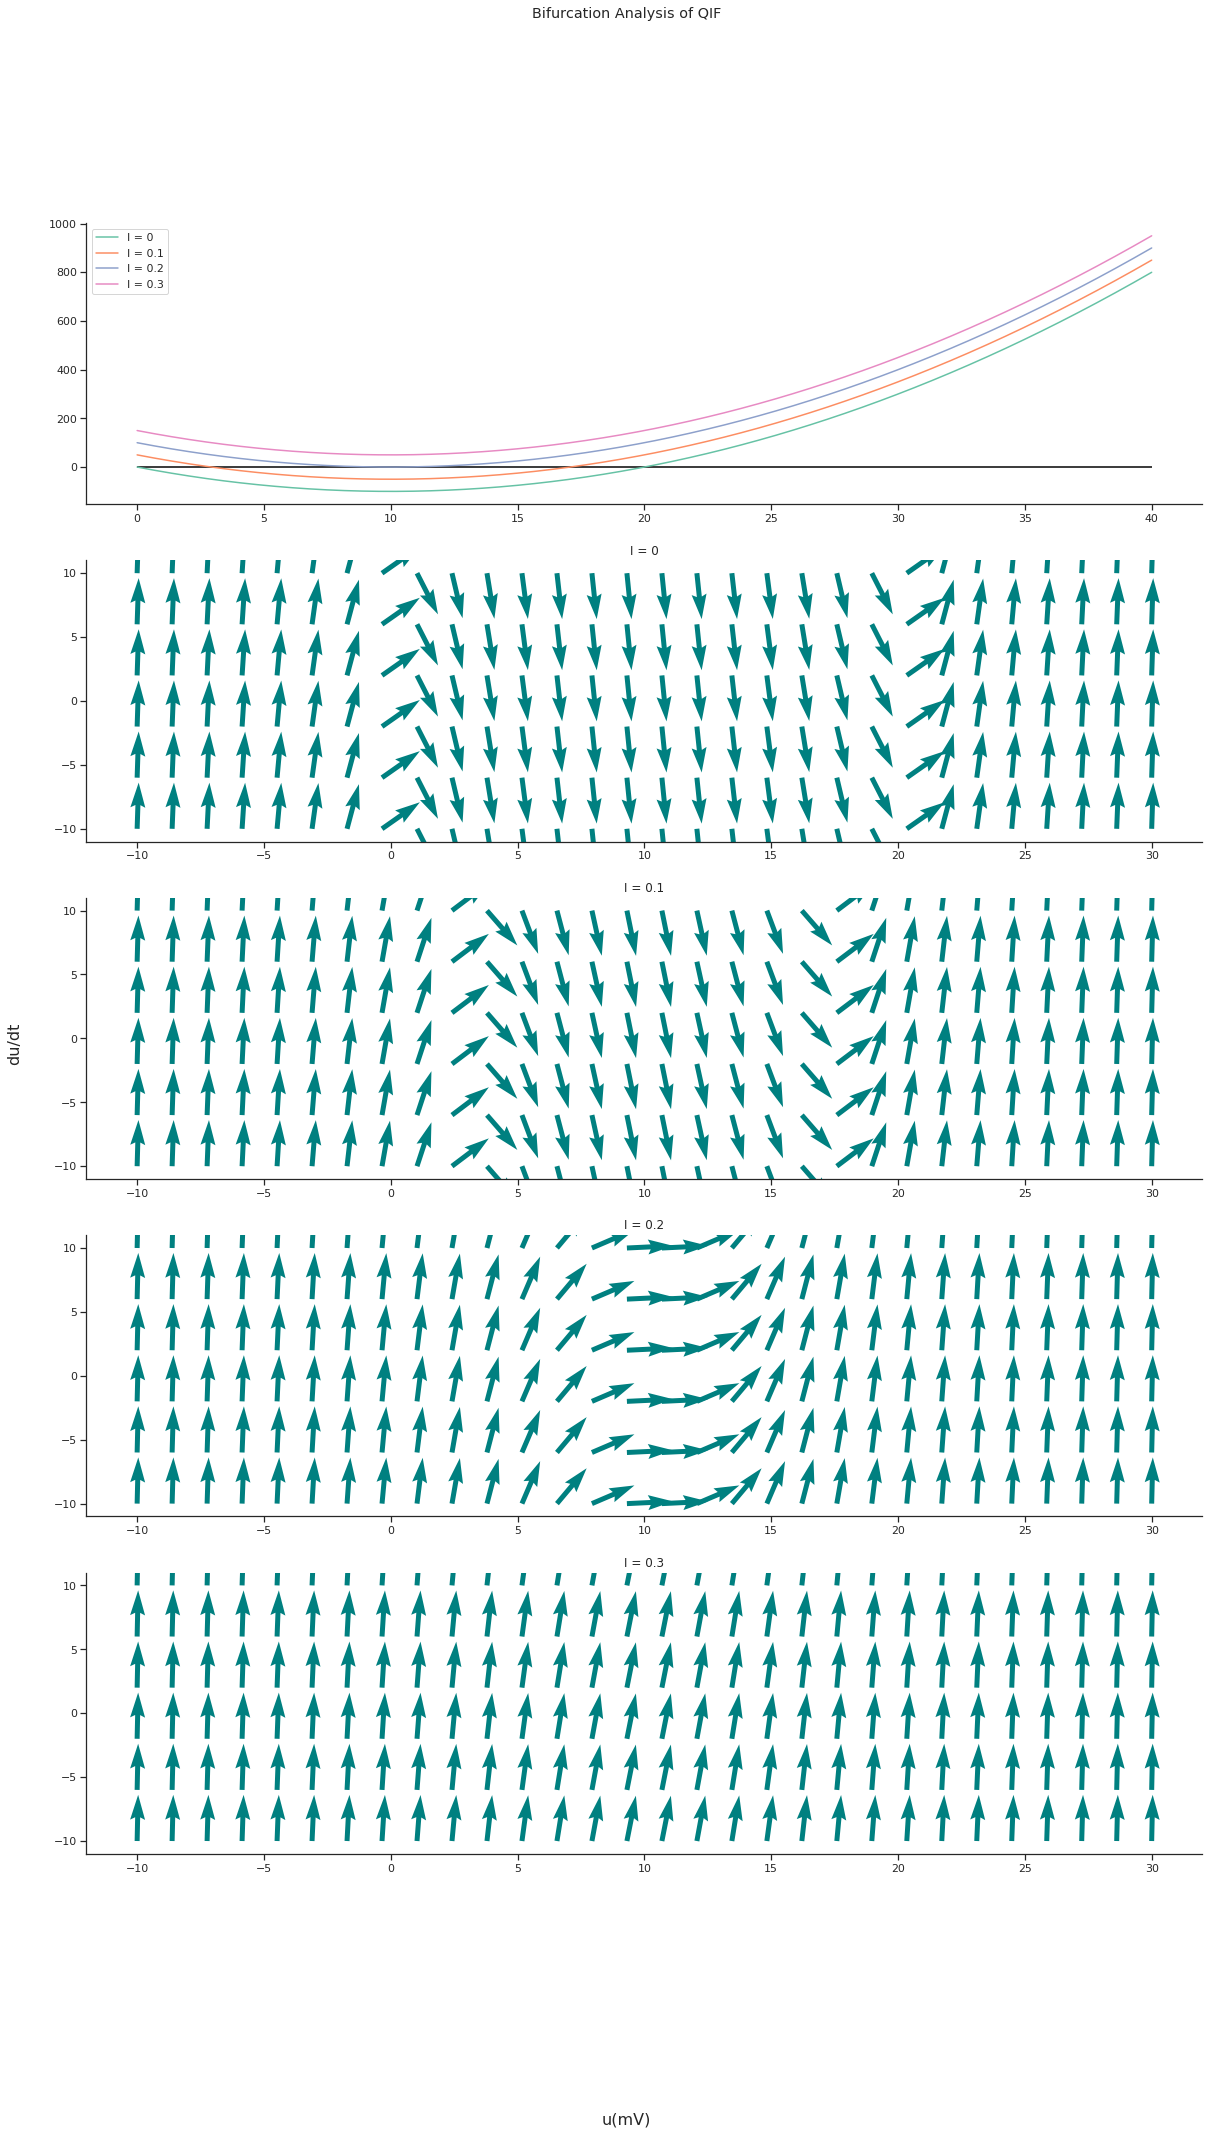

In [7]:
fig, ax = plt.subplots(5, 1, figsize=(20,5*6))
u = np.linspace(0, 40, 1000)
for i in range(len(inputs)):
    ax[0].plot(u, RHS(a0, u, u_rest, u_c, R, inputs[i]), label="I = {}".format(inputs[i]))
    X, Y = np.mgrid[-10:30:30j, -10:10:6j]
    U = 1
    V = RHS(a0, X, u_rest, u_c, R, inputs[i])/tau_m
    N = np.sqrt(U**2+V**2)  # there may be a faster numpy "normalize" function
    U2, V2 = U/N, V/N
    ax[i+1].quiver(X, Y, U2, V2, scale_units='height', color='teal')
    ax[i+1].locator_params(integer=True)
    ax[i+1].set_title('I = {}'.format(inputs[i]))
    sns.despine()
ax[0].legend()
ax[0].hlines(0, 0, 40)
fig.suptitle('Bifurcation Analysis of QIF')
fig.text(0.5, 0.0, 'u(mV)', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'du/dt', va='center', rotation='vertical', fontsize=16)
sns.despine()

(b) Simulate the QIF for different values of constant input current, as you pass the bifurcation point observed in the previous problem. You will have to set the threshold around
60 mV. Be careful since the voltage can grow quickly.

In [8]:
def QIF(tau_m, a0, u, u_rest, u_c, R, I):
    return (a0 * (u - u_rest) * (u - u_c) + R * I)/tau_m

In [9]:
def euler_QIF(tau_m, a0, u_rest, u_c, R, I, max_time, dt, u_threshold): 
    u = []
    time = []
    u.append(u_rest)
    time.append(0)
    current_step = 0
    while time[current_step] < max_time: 
        if u[current_step] > u_threshold:
            u.append(u_rest)
            time.append(time[current_step] + dt)
        else:
            u.append(u[current_step] + dt * QIF(tau_m, a0, u[current_step], u_rest, u_c, R, I))
            time.append(time[current_step] + dt)
        current_step += 1
    return time, u

In [10]:
tau_m = 10
R = 500
u_rest = 0
u_c = 20
I = [0.1, 0.2, 0.3, 0.4]
a0 = 1
max_time = 20
dt = 0.005
u_threshold = 60

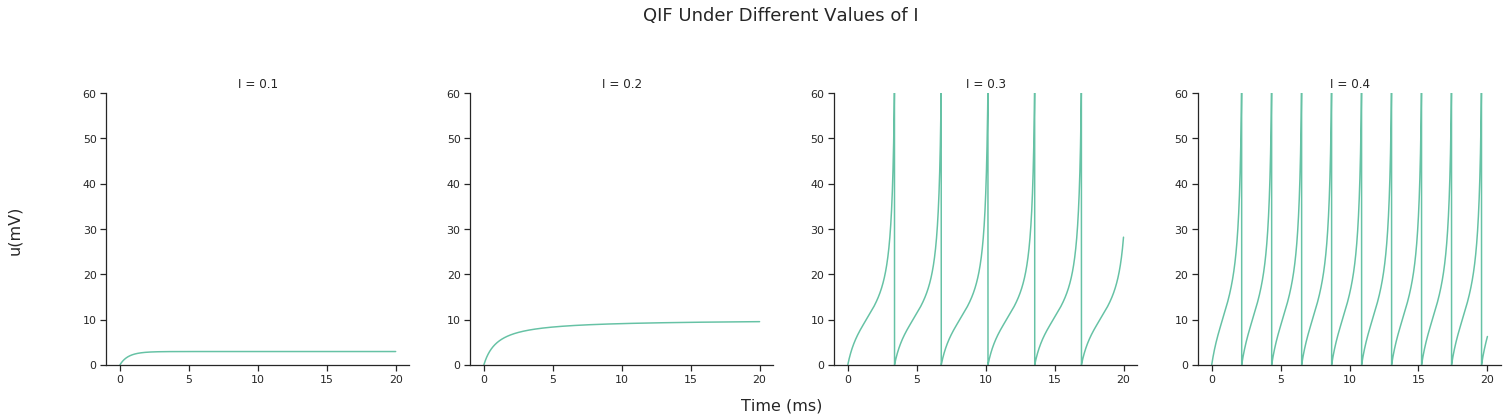

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))
fig.suptitle('QIF Under Different Values of I', fontsize=18, y=1.12)
fig.text(0.5, 0.0, 'Time (ms)', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'u(mV)', va='center', rotation='vertical', fontsize=16)
for i in range(len(I)):
    time, u, = euler_QIF(tau_m, a0, u_rest, u_c, R, I[i], max_time, dt, u_threshold)
    ax[i].plot(time, u)
    ax[i].set_title("I = {}".format(I[i]))
    sns.despine()
    ax[i].set_ylim(0, u_threshold)
    ax[i].locator_params(integer=True)

(c) Assume the input is described by a Poisson process. Compute the firing rate as a func-
tion of the input rate, assuming that the weight of each synapse is $w_k = 1$, with current measured in pA. Assume that each input spike results in an instant depolarization. As a result model the effect of each spike as an instantaneous increase in the membrane potential by $\Delta u = 0.5 mV$ You can compute the output rate by recording the times between consecutive spikes, and dividing by the total number of spikes. Do this for $a_0 = 1, 2,$ and $5$.

In [12]:
def QIF(tau_m, a0, u, u_rest, u_c):
    return (a0 * (u - u_rest) * (u - u_c))/tau_m

def poisson_input(rate, dt):
    return np.random.poisson(rate * dt)


def spike_train_QIF(tau_m, a0, u_rest, u_c, max_time, dt, I, du): 
    u = []
    time = []
    u.append(u_rest)
    time.append(0)
    current_step = 0
    time_between_spikes = 0
    num_spikes = 0
    while time[current_step] < max_time: 
        if poisson_input(I, dt) > 0:
            u.append(u[current_step] + du)
            time.append(time[current_step] + dt)
            num_spikes += 1
        else:
            u.append(u[current_step] + dt * QIF(tau_m, a0, u[current_step], u_rest, u_c))
            time.append(time[current_step] + dt)
            time_between_spikes += dt
        current_step += 1
        
    return time, u, (time_between_spikes / num_spikes)

In [13]:
tau_m = 10
u_rest = 0
u_c = 20
R = 0
I = 0.3
a0 = [1, 2, 5]
max_time = 100
dt = 0.005
du = 0.5

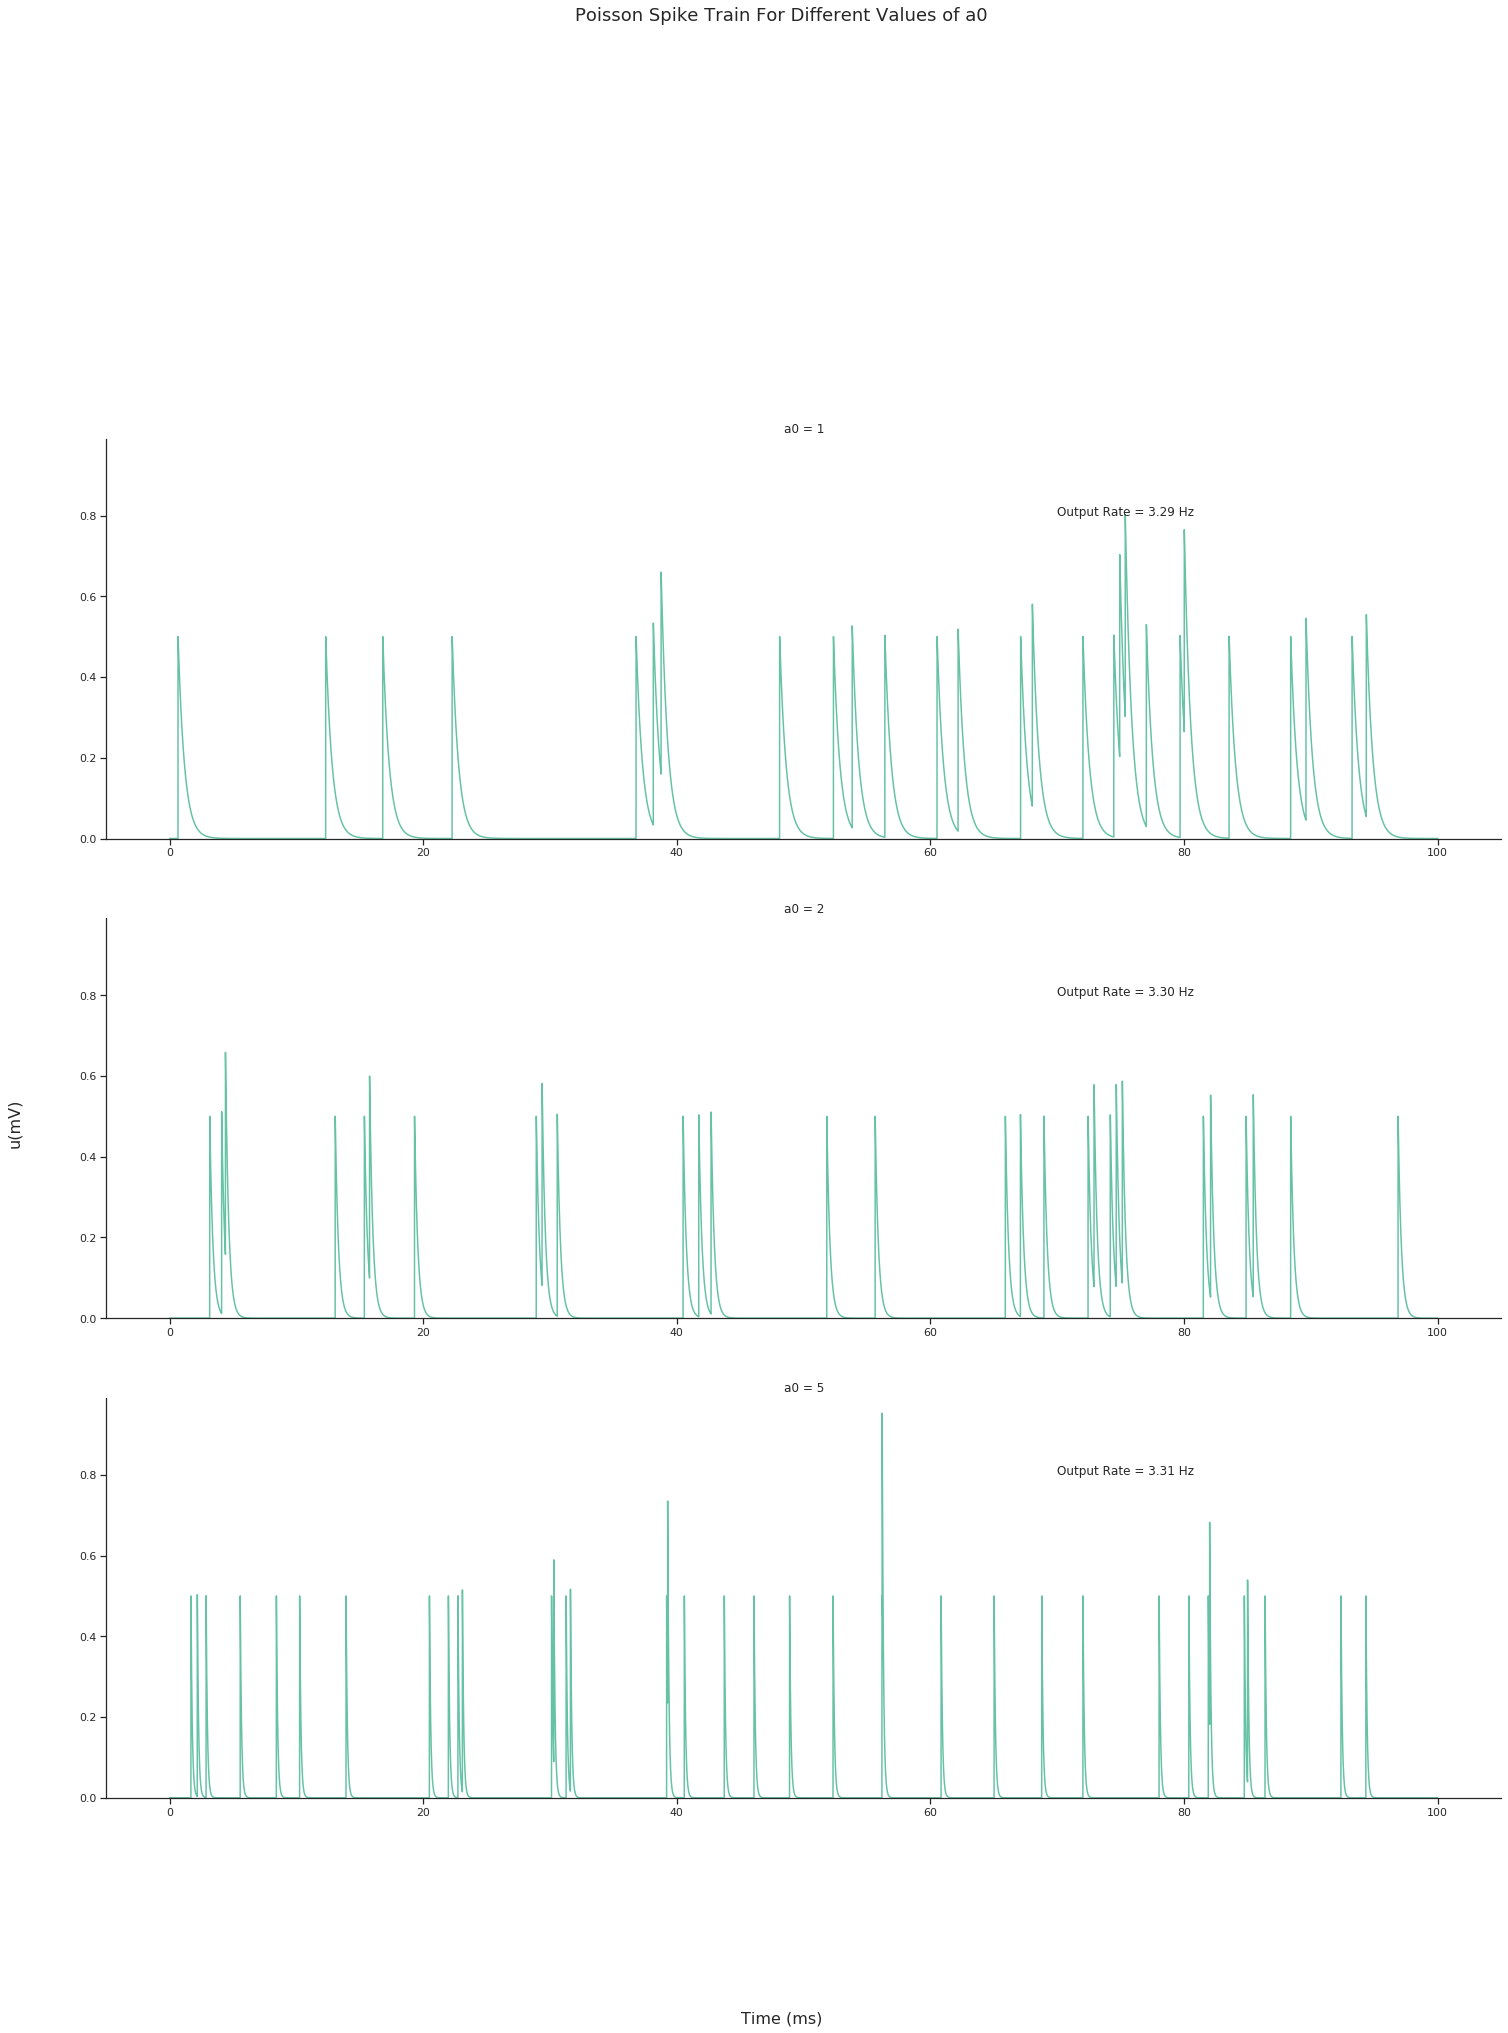

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(25,25))
fig.suptitle('Poisson Spike Train For Different Values of a0', fontsize=18, y=1.12)
fig.text(0.5, 0.0, 'Time (ms)', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'u(mV)', va='center', rotation='vertical', fontsize=16)
for i in range(len(a0)):
    time, u, _ = spike_train_QIF(tau_m, a0[i], u_rest, u_c, max_time, dt, I, du)
    _, _,output_rate = spike_train_QIF(tau_m, a0[i], u_rest, u_c, 10000, dt, I, du)
    ax[i].plot(time, u)
    ax[i].set_title("a0 = {}".format(a0[i]))
    sns.despine()
    ax[i].set_ylim(0, 0.99)
    ax[i].text(70, 0.8, 'Output Rate = {0:.2f} Hz'.format(output_rate))
    ax[i].locator_params(integer=True)